# Estimation of internal nodes and phylogenetic mean from shape observations

In this notebook we estimate the inner nodes and mean of a phylogenetic tree, where only the leaf node values are known. This aim is the same as in the example notebook mean_estimation.ipynb. The current notebook adds another layer of complexity in that nodes values are no longer assumed to be vectors, but _shapes_; in our case discretized outline curves describing the wing morphology of certain butterfly species. The inner nodes thus represent wing shapes of ancestral butterfly species.

As in mean_estimation.ipynb we use a simple, recursive estimator for the inner nodes; any inner node will be estimated as a weighted mean of its children. Due to the _non-linear_ nature of shapes, we cannot use the ordinary 'Euclidean' weighted mean. Luckily, the python library _jaxgeometry_ is built for handling such data, including computing weighted means of shape observations. Below, we construct a 'fuse' function which computes such weighted means of shapes using jaxgeometry. 


__Content of the notebook__

1. We load a dataset of shapes of 4 butterfly species and an associated evolutionary tree (phylogeny) for these species 

2. We estimate and plot the inner nodes, i.e. the estimated shapes of ancestral butterfly species. 

## 1. load example data

The example data is 4 observations of butterfly wings, also described in Baker et. al. 2024, https://doi.org/10.48550/arXiv.2402.01434 .
We represent each wing by 25 landmarks.  

We also load a phylogeny for these 4 species, i.e. a tree with 4 leaf nodes.

In [39]:
# Create a new Hyperiax client

import hyperiax
from jax.random import PRNGKey, split
import jax
from jax import numpy as jnp

key = PRNGKey(0)

In [ ]:
import pandas as pd
import numpy as np

# Load all files
tree_string = requests.get("https://raw.githubusercontent.com/MichaelSev/Hyperiax_data/main/tree.txt").text
tree = hyperiax.tree.builders.tree_from_newick(tree_string)
landmarks = pd.read_csv("https://raw.githubusercontent.com/MichaelSev/Hyperiax_data/main/landmarks.csv", sep=",", header=None)

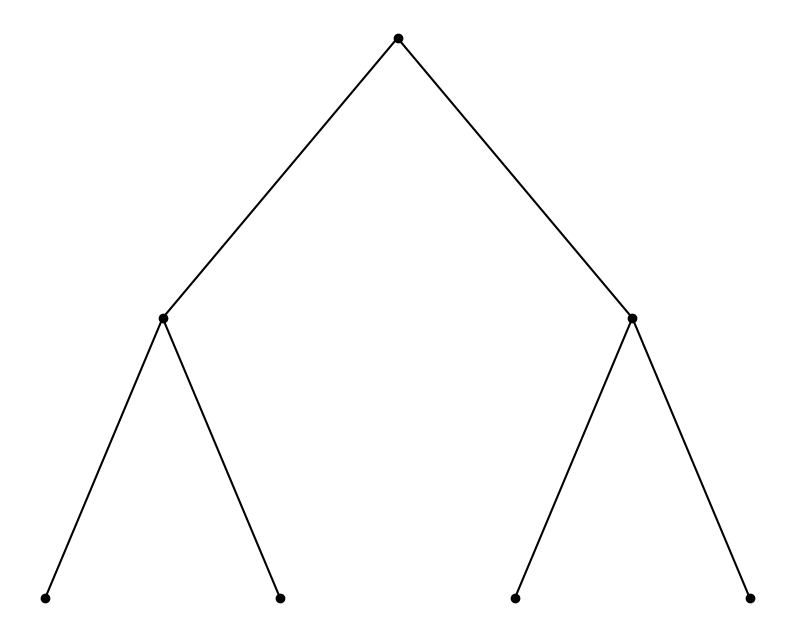

((Graphium_evemon:0.06883,Graphium_sarpedon:0.06835)QS1810:0.13941,(Atrophaneura_dixoni:0.0434,Pachliopta_aristolochiae:0.05484)QS1845:0.16755)QS1804:0;



In [8]:
tree.plot_tree()
print(tree_string)

In [9]:
# The name of the landmarks are placed in the tree, alongside with the edgelength 

# add landmarks
for leaf,l in zip(tree.iter_leaves(),landmarks):
    leaf.data["landmarks"]= jnp.column_stack((landmarks.iloc[l].values[0::2],landmarks.iloc[l].values[1::2]))

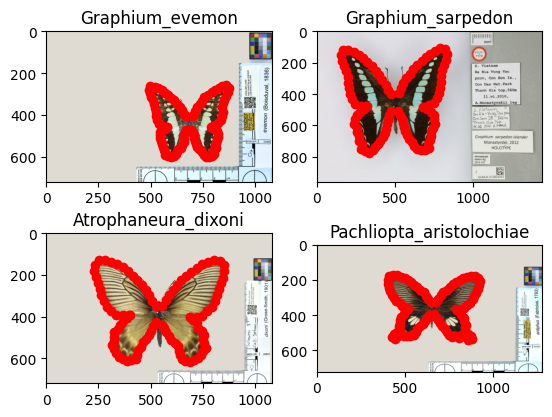

In [10]:
# Example of landmarks 
import matplotlib.pyplot as plt
from PIL import Image

main_path = "https://github.com/MichaelSev/Hyperiax_data/raw/main/image/"

list_of_names =["img0.jpg","img1.jpg","img2.jpg","img3.jpg"]
for leaf,i in zip(tree.iter_leaves(),range(4)):
    plt.subplot(2,2,i+1)
    im = Image.open(requests.get(main_path+list_of_names[i], stream=True).raw)
    implot = plt.imshow(im)
    plt.scatter(leaf.data["landmarks"][:,0],leaf.data["landmarks"][:,1],c="r")
    plt.title(str(leaf.name))




## 2. compute inner nodes (i.e. ancestral shapes)

We compute the inner nodes of the tree, i.e. the wing shapes of ancestral species. For this we need to define a 'fuse' function which computes a non-linear version of a weighted mean: each inner node is a non-linear weighted mean of its children nodes. The particular non-linear weighted mean we compute is based on the LDDMM framework, as implemented in the jaxgeometry library.

In [12]:
# Requires Jaxdifferentalgeometry package

from jaxgeometry.manifolds.landmarks import *   
from jaxgeometry.Riemannian import metric
from jaxgeometry.dynamics import Hamiltonian
from jaxgeometry.Riemannian import Log
from jaxgeometry.dynamics import flow_differential

from hyperiax.execution import LevelwiseTreeExecutor, DependencyTreeExecutor
from hyperiax.models import UpLambda, DownLambda
from hyperiax.models.functional import pass_up

from functools import partial
from scipy.spatial import distance 

In [13]:
# Corresponding to pass_up

up = pass_up('landmarks', 'edge_length')

def fuse(child_landmarks,child_edge_length, **kwargs):
    def lddmm(childxs1,childxs2,parent_placement):

  
        # Estimate the avarage distance between each landmark,
           # if the distance is not approx the same for each set, this shoul dbe the mean of both 
        sigma_k =(np.mean([distance.euclidean(childxs1[i], childxs1[i+1]) for i in range(len(childxs1) - 1)]) +
                np.mean([distance.euclidean(childxs2[i], childxs2[i+1]) for i in range(len(childxs2) - 1)]))/2
        #print(sigma_k,parent_placement)
        n_landmarks = jnp.shape(childxs1)[0]
        
        M = landmarks(n_landmarks,k_sigma=sigma_k*jnp.eye(2)) 
        # Riemannian structure

        metric.initialize(M)
    
        q = M.coords(jnp.vstack(childxs1).flatten())
        v =  (jnp.array(jnp.vstack(childxs2).flatten()),[0])
      
        Hamiltonian.initialize(M)

        # Logarithm map
        Log.initialize(M,f=M.Exp_Hamiltonian)
       
        # Estimate momentum 
        p = M.Log(q,v)[0]

        # Hamiltonian 
        (_,qps,charts_qp) = M.Hamiltonian_dynamics(q,p,dts(n_steps=100))

        #lift
        flow_differential.initialize(M)
        _,dphis,_ = M.flow_differential(qps,dts())
        dphi_t = dphis[parent_placement]
        eta_t = jax.vmap(lambda A,v: jnp.dot(A.T,v))(dphi_t,p.reshape((M.N,M.m)))

        return qps[:,0][parent_placement].reshape(-1,2),eta_t



    parent_placement = int(child_edge_length[0]/sum(child_edge_length)*100)-1 

   
    lddmm_landmarks, lddmm_eta_left  = lddmm(child_landmarks[0],child_landmarks[1],parent_placement)
    _, lddmm_eta_right = lddmm(child_landmarks[1],child_landmarks[0],100-parent_placement)
    

    return {'landmarks':lddmm_landmarks,"eta_left":lddmm_eta_left,"eta_right":lddmm_eta_right}

  

In [14]:
upmodel = UpLambda(up, fuse)
root_exe = DependencyTreeExecutor(upmodel, batch_size=100)
calc_tree = root_exe.up(tree)

#### 2.1 plots

We can now plot one of the estimated inner nodes, computed as the weighted mean of two neighbouring leaf-node shapes. The two leaf shapes are represented by the red and green points, the estimated inner node is represented by the blue points.

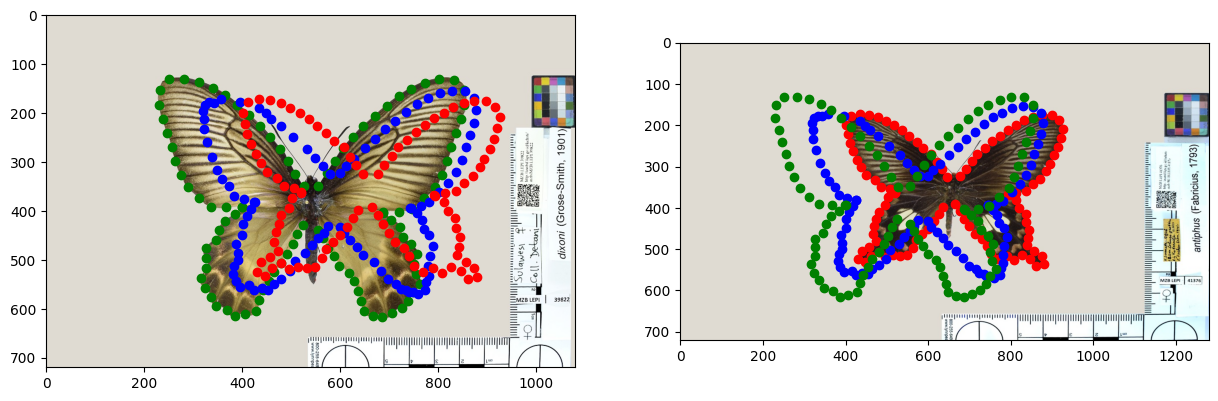

In [38]:
# Illustrate the results
plt.subplot(1, 2, 1)
# Load image 
im = Image.open(requests.get(main_path+"img2.jpg", stream=True).raw)
implot = plt.imshow(im)

# PLot points
plt.scatter(calc_tree.root.children[1].children[0].data["landmarks"][:,0], calc_tree.root.children[1].children[0].data["landmarks"][:,1], color='green')
plt.scatter(calc_tree.root.children[1].data["landmarks"][:,0], calc_tree.root.children[1].data["landmarks"][:,1], color='blue')
plt.scatter(calc_tree.root.children[1].children[1].data["landmarks"][:,0], calc_tree.root.children[1].children[1].data["landmarks"][:,1], color='red')

#plt.scatter(calc_tree.root.data["landmarks"][:,0], calc_tree.root.data["landmarks"][:,1], color='green')
#plt.scatter(calc_tree.root.children[0].children[1].data["landmarks"][:,0], calc_tree.root.children[0].children[1].data["landmarks"][:,1], color='red')

plt.subplot(1, 2, 2)
# load image
im = Image.open(requests.get(main_path+"img3.jpg", stream=True).raw)
implot = plt.imshow(im)

# PLot points
plt.scatter(calc_tree.root.children[1].children[1].data["landmarks"][:,0], calc_tree.root.children[1].children[1].data["landmarks"][:,1], color='red')
plt.scatter(calc_tree.root.children[1].data["landmarks"][:,0], calc_tree.root.children[1].data["landmarks"][:,1], color='blue')
plt.scatter(calc_tree.root.children[1].children[0].data["landmarks"][:,0], calc_tree.root.children[1].children[0].data["landmarks"][:,1], color='green')

#plt.scatter(calc_tree.root.data["landmarks"][:,0], calc_tree.root.data["landmarks"][:,1], color='green')
#plt.scatter(calc_tree.root.children[0].children[0].data["landmarks"][:,0], calc_tree.root.children[0].children[0].data["landmarks"][:,1], color='blue')

plt.show()


The points on the left and right figures are identical, the only difference is the superimposed image.

Next, we plot all leaf nodes (points in light colors) along with the estimated root node shape (blue points), i.e. the common ancestor of all 4 species.

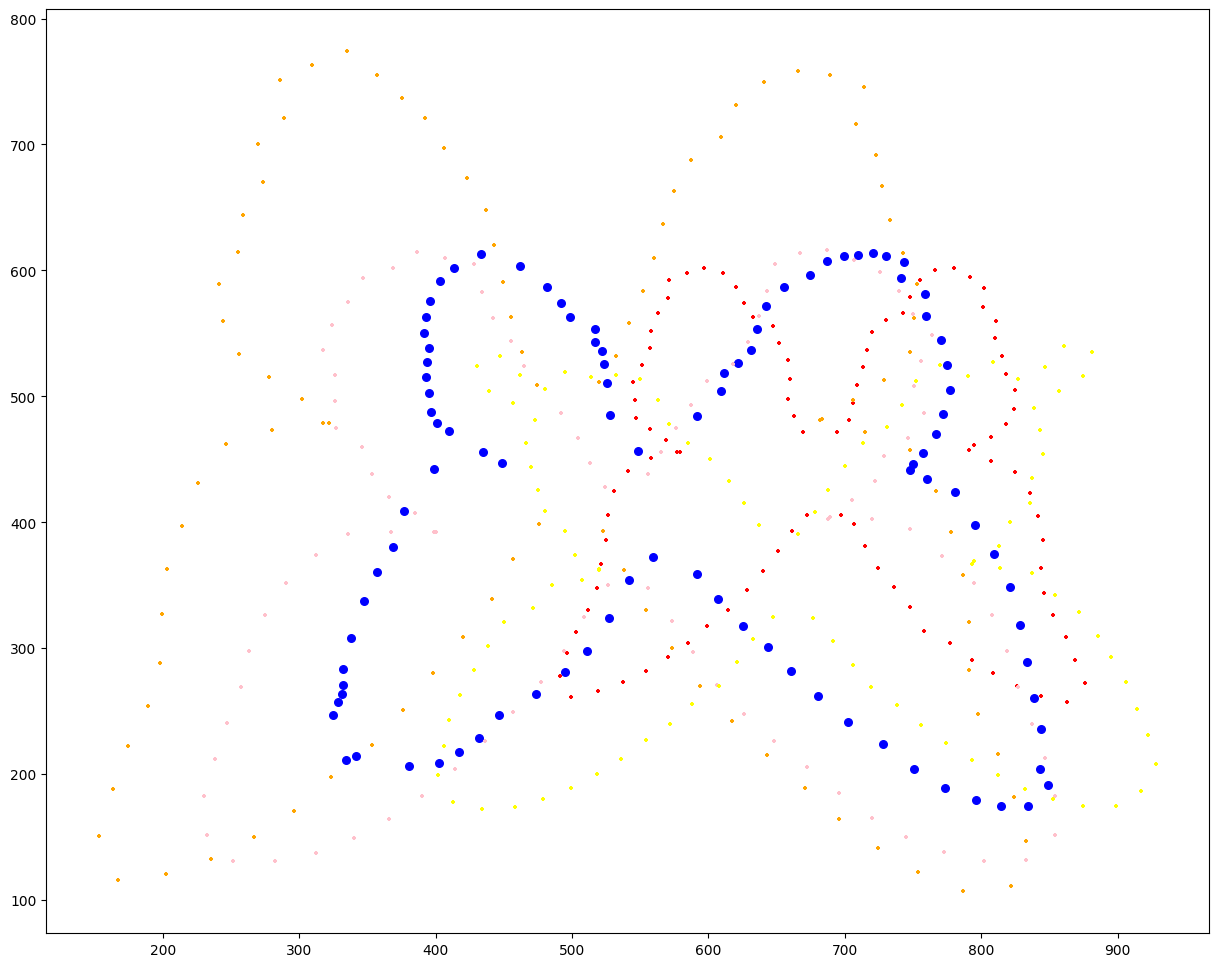

In [37]:
# Illustrate the results

obs_size = 10
root_size = 30

# PLot points
plt.scatter(calc_tree.root.data["landmarks"][:,0], 
            -calc_tree.root.data["landmarks"][:,1], color='blue', s=root_size)
plt.scatter(calc_tree.root.children[0].children[0].data["landmarks"][:,0], 
            -calc_tree.root.children[0].children[0].data["landmarks"][:,1], color='red',s=obs_size, marker='+')
plt.scatter(calc_tree.root.children[0].children[1].data["landmarks"][:,0], 
            -calc_tree.root.children[0].children[1].data["landmarks"][:,1], color='orange', s=obs_size, marker='+')
plt.scatter(calc_tree.root.children[1].children[0].data["landmarks"][:,0], 
            -calc_tree.root.children[1].children[0].data["landmarks"][:,1], color='pink', s=obs_size, marker='+')
plt.scatter(calc_tree.root.children[1].children[1].data["landmarks"][:,0], 
            -calc_tree.root.children[1].children[1].data["landmarks"][:,1], color='yellow', s=obs_size, marker='+')

#plt.scatter(calc_tree.root.data["landmarks"][:,0], calc_tree.root.data["landmarks"][:,1], color='green')
#plt.scatter(calc_tree.root.children[0].children[1].data["landmarks"][:,0], calc_tree.root.children[0].children[1].data["landmarks"][:,1], color='red')

plt.show()